## Описание проекта

Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цель: персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

Задачи:
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
!pip install shap -q
!pip install -U scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 123

## Обзор данных

In [5]:
df_file = pd.read_csv('/datasets/market_file.csv', sep=',').set_index('id', drop=True)
df_market_money = pd.read_csv('/datasets/market_money.csv', sep=',').set_index('id', drop=True)
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',').set_index('id', drop=True)
df_time = pd.read_csv('/datasets/market_time.csv', sep=',').set_index('id', drop=True)
df=[df_file, df_market_money, df_money, df_time]

### Данные о поведении покупателя

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [6]:
df_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (**целевой признак**): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [7]:
df_file.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


В признаках отсутствуют аномальные значения

### Данные о выручке

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [8]:
df_market_money.head()

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


In [9]:
df_market_money.describe()

,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


Максимальное значение сильно отличается от значения 75 квантиля - необходимо проверить данные по выручке на выбросы.

### Данные о среднемесячной прибыли

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [10]:
df_money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


In [11]:
df_money.describe()

,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


В прибыли отсутствуют аномальные значения

### Данные о времени, проведенном на сайте

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [12]:
df_time.head()

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдцщий_месяц,13
215349,текущий_месяц,10
215349,предыдцщий_месяц,12
215350,текущий_месяц,13


In [13]:
df_time.describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


В данных о времени на сайте отсутствуют аномальные значения

### Вывод
Для выполнения работы были переданы 4 датасета:
1. df_file - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. df_market_money - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. df_money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
4. df_time - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Целевой признак - Покупательская активность
В признаках отствуют аномальные значения, за имсключением значений Выручки, что будет исследованно далее.

## Предобработка данных

In [14]:
df_file['Покупательская активность'] = df_file['Покупательская активность'].apply(
    lambda x: 1 if x=='Снизилась' else 0)

In [15]:
cat_columns = []
num_columns = []

for col_name in df_file.columns:
    
    if isinstance(df_file[col_name].iloc[0], str):
        cat_columns.append(col_name)
    else:
        num_columns.append(col_name)
num_columns.remove('Покупательская активность')       
print('Count numerical columns:', len(num_columns))
print('Count categorical columns:', len(cat_columns))

Count numerical columns: 8
Count categorical columns: 3


In [16]:
for cat_col in cat_columns:
    print(cat_col)
    print(df_file[cat_col].unique())
            

Тип сервиса
['премиум' 'стандартт' 'стандарт']
Разрешить сообщать
['да' 'нет']
Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [17]:
df_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [18]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [19]:
df_file['Тип сервиса'] = df_file['Тип сервиса'].str.replace('стандартт', 'стандарт')
df_time['Период'] = df_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [20]:
print(df_file.duplicated().sum())
df_file=df_file.drop_duplicates()

11


In [21]:
pd.DataFrame(df_file[num_columns].isna().mean()*100).style.background_gradient('coolwarm')

,0
Маркет_актив_6_мес,0.000000
Маркет_актив_тек_мес,0.000000
Длительность,0.000000
Акционные_покупки,0.000000
Средний_просмотр_категорий_за_визит,0.000000
Неоплаченные_продукты_штук_квартал,0.000000
Ошибка_сервиса,0.000000
Страниц_за_визит,0.000000


В процессе предобработки данных были выполнены:
- Исследованы и удалены при наличии неявные дубликаты во всех датасетах
- Признаки поделены на качественные и количественные

## Исследовательский анализ данных

### Исследования целевого признака

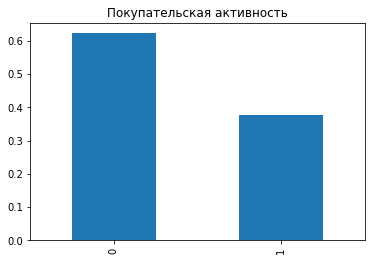

In [22]:
df_file['Покупательская активность'].value_counts(normalize=True).plot(kind='bar', title='Покупательская активность');

В целом признаке отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как снижение активности фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных. Его нужно будет учитывать во время подготовки данных и обучения модели

### Качественные признаки

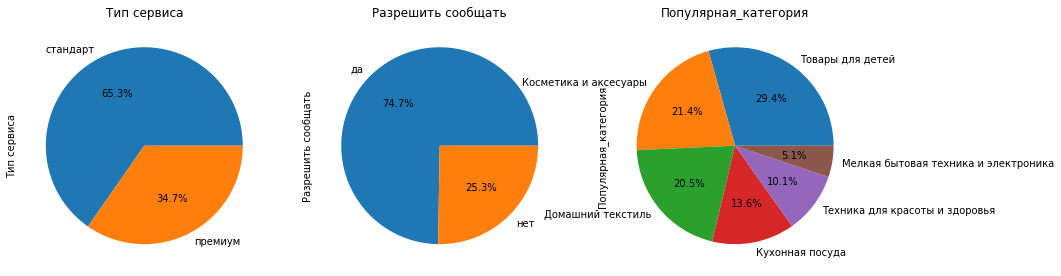

In [23]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    df_file.loc[df_file['Покупательская активность']==1][col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col, 
                              autopct='%1.1f%%')
plt.show();

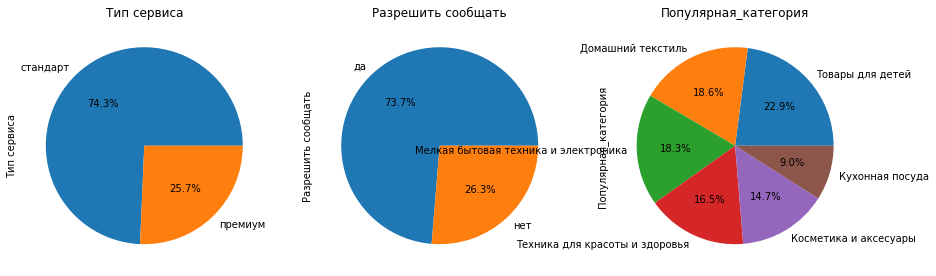

In [24]:
fig, axs = plt.subplots(1, len(cat_columns), figsize=(15, 5))
for i, col in enumerate(cat_columns):
    df_file.loc[df_file['Покупательская активность']==0][col].value_counts().plot(kind='pie',
                              ax=axs[i],
                              title = col, 
                              autopct='%1.1f%%')
plt.show();

Среди пользователей, у которых покупательская активность снизилась, меньше доля пользователей премиум сервиса, но больше для подписок на рассылку. Самая популярная категория у обоих групп Товары для детей. В целом для обоих групп пользователей, разделенных по целевому признаку, не наблюдается существенных различий в интересах по категориям товаров

### Количественные признаки

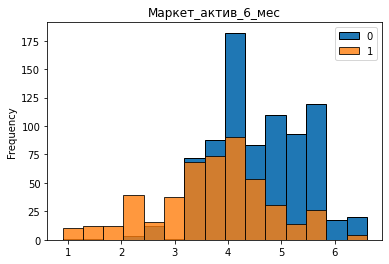

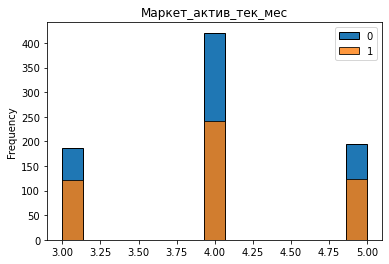

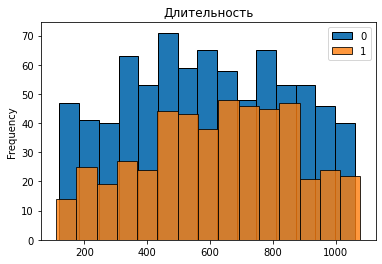

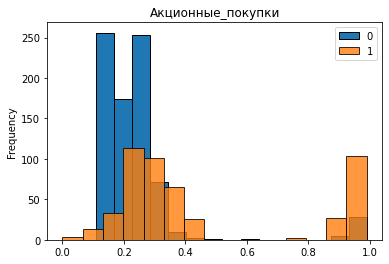

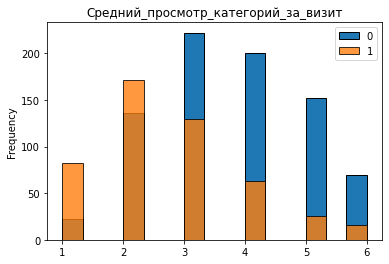

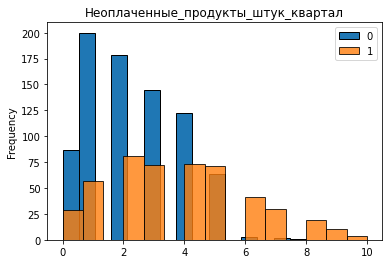

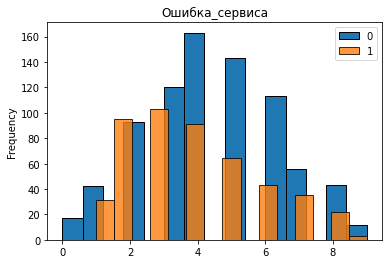

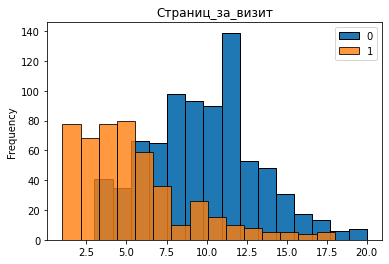

In [25]:
for col in num_columns:
    df_file.loc[df_file['Покупательская активность']==0][col].plot(
        kind='hist', bins= 15, title = col, edgecolor='black', alpha = 1)
    df_file.loc[df_file['Покупательская активность']==1][col].plot(
        kind='hist', bins= 15, title = col, edgecolor='black', alpha = 0.8)
    labels= ["0","1"]
    plt.legend(labels)
    plt.show();

Анализ распределения количественных признаков показал, что пользователи, у которых снизилась активность: - просматривают меньше страниц при посещении сайта
- чаще имеют дело с ошибками сервиса
- имеют больше неоплаченных продуктов
- просматривают за визит меньше категорий

In [26]:
df_file['Акционные_покупки'] = df_file['Акционные_покупки'].apply(
    lambda x: 1 if x>0.6 else 0)

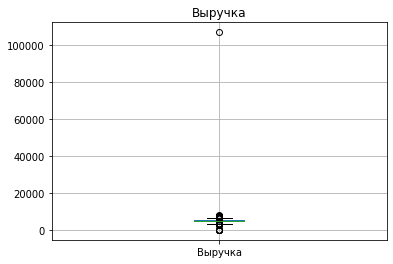

In [27]:
df_market_money.boxplot(column='Выручка')
plt.title('Выручка')
plt.show()

В данных о выручке явно присутсвуют выбросы. Удалим самое неправдоподобно большое знасчение в сравнении с остальными данными, и также выручка не может быть равна 0.

In [28]:
df_market_money = df_market_money.loc[
    (df_market_money['Выручка'] < 20000) & (df_market_money['Выручка'] != 0)]

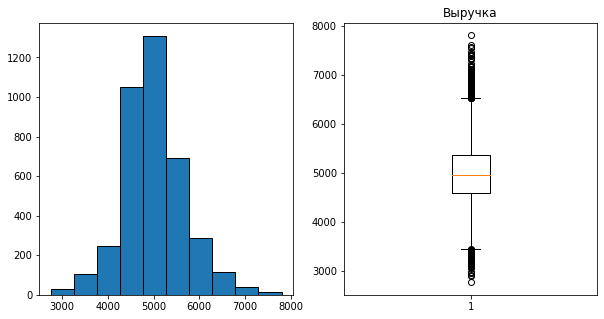

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(df_market_money['Выручка'], edgecolor='black')
axes[1].boxplot(df_market_money['Выручка'])
plt.title('Выручка');

Значени выручки распределены нормально, но отмечается много выбросов за счет явного преобладания значений выручки близким к среднему.

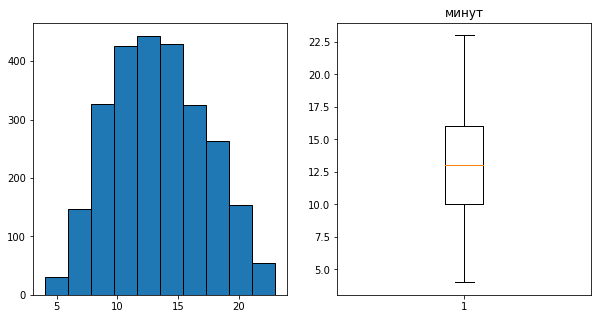

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(df_time['минут'], edgecolor='black')
axes[1].boxplot(df_time['минут'])
plt.title('минут');

Данные о минутах проведенных на сайте распределены нормально, выбросы отсутсвуют

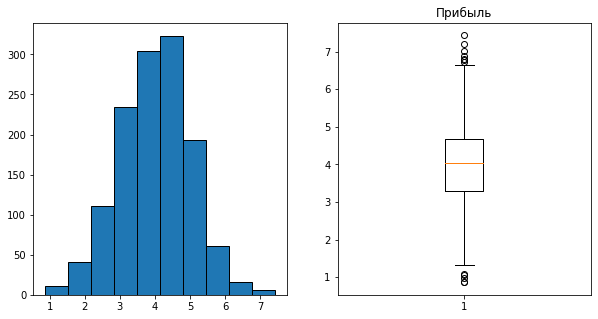

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(df_money['Прибыль'], edgecolor='black')
axes[1].boxplot(df_money['Прибыль'])
plt.title('Прибыль');

Данные о прибыли проведенных на сайте распределены нормально, присутствует незначительное кол-во выбросов

### Вывод

В целом признаке Покупательская активность отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как снижение активности фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных. Его нужно будет учитывать во время подготовки данных и обучения модели.

Среди пользователей, у которых покупательская активность снизилась, меньше доля пользователей премиум сервиса, но больше для подписок на рассылку. Самая популярная категория у обоих групп Товары для детей. В целом для обоих групп пользователей, разделенных по целевому признаку, не наблюдается существенных различий в интересах по категориям товаров

Анализ распределения количественных признаков показал, что пользователи, у которых снизилась активность: - просматривают меньше страниц при посещении сайта
- чаще имеют дело с ошибками сервиса
- имеют больше неоплаченных продуктов
- просматривают за визит меньше категорий

После удаления одного максимального выброса, значения выручки описываются нормальным распределением, но отмечается все еще много выбросов за счет явного преобладания значений выручки близким к среднему.
Данные о минутах проведенных на сайте распределены нормально, выбросы отсутсвуют
Данные о прибыли проведенных на сайте распределены нормально, присутствует незначительное кол-во выбросов

##  Объединение таблиц

Отберем клиентов с покупательской активностью не менее трёх месяцев

In [32]:
df_mm = pd.pivot_table(df_market_money, index='id', columns='Период', values='Выручка')
df_mm.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
for col in df_mm.columns:
    df_mm = df_mm.loc[df_mm[col] != 0]
df_mm.head(10)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
215354,5685.0,4503.0,5869.6
215355,3263.0,4749.0,3772.6
215356,4146.5,4433.0,4566.4


In [33]:
df_t = pd.pivot_table(df_time, index='id', columns='Период', values='минут')
df_t.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
df_t

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [34]:
df_full=df_file.join(df_mm, how='left')
df_full=df_full.join(df_t, how='left')
df_full=df_full.join(df_money, how='left')
df_full

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
id,,,,,,,,,,,,,,,,,,
215348,1,премиум,да,3.4,5,121,0,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14,0.98
215349,1,премиум,да,4.4,4,819,1,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
215350,1,стандарт,нет,4.9,3,539,0,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
215351,1,стандарт,да,3.2,5,896,1,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
215352,1,стандарт,нет,5.1,3,1064,1,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,0,стандарт,да,6.6,3,318,0,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,4.44
216644,0,стандарт,нет,5.1,4,454,0,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,6.11
216645,0,стандарт,да,4.1,3,586,0,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,3.29


In [35]:
pd.DataFrame(df_full.isna().mean()*100).style.background_gradient('coolwarm')

,0
Покупательская активность,0.000000
Тип сервиса,0.000000
Разрешить сообщать,0.000000
Маркет_актив_6_мес,0.000000
Маркет_актив_тек_мес,0.000000
Длительность,0.000000
Акционные_покупки,0.000000
Популярная_категория,0.000000
Средний_просмотр_категорий_за_визит,0.000000
Неоплаченные_продукты_штук_квартал,0.000000


In [36]:
df_full=df_full.dropna()

## Корреляционный анализ

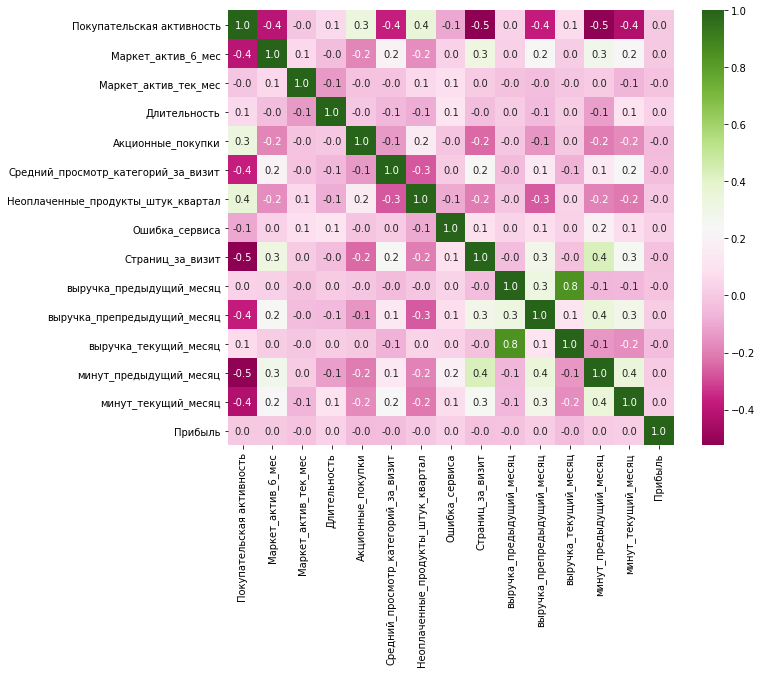

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(df_full.corr(), annot=True, cmap='PiYG', fmt=".1f")
plt.show()

Мультиколлинеарность признаков отсутствует. Наиболее высокая корреляция признаков наблюдается между выручкой в текущем и прошлом месяце. 
Самый высокий коэффциент корреляции с целевым признаком у признака Страниц за визит

## Подготовка к моделированию

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['Покупательская активность'], axis=1),
    df_full['Покупательская активность'],
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = df_full['Покупательская активность'])


X_train.shape, X_test.shape


ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns = num_columns+['выручка_текущий_месяц',
                            'минут_текущий_месяц', 'выручка_предыдущий_месяц',
                            'минут_предыдущий_месяц', 'выручка_препредыдущий_месяц'
                           ]

In [39]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

In [40]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                    ['да', 'нет'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [41]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [42]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
#     словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.01,0.01,1,10,100],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': ['1', '2', '3', '4']
 
    }
]


In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

In [44]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8552896673656512


### Вывод

Лучшая модель и её параметры:
LogisticRegression(C=3, penalty='l1', random_state=123,
                                    solver='liblinear'))])
Метрика лучшей модели на тренировочной выборке: 0.9086058881676875
Метрика ROC-AUC на тестовой выборке: 0.8552896673656512

## Анализ важности признаков

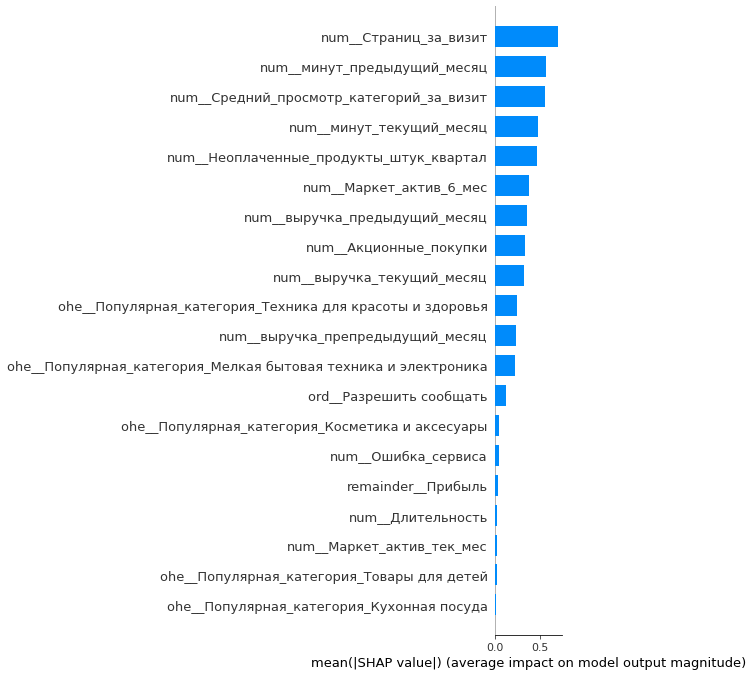

In [45]:
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
 
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test) 
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_Train)

shap_values = explainer(x_Test)
shap.summary_plot(shap_values, x_Test, plot_type="bar", 
                  feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out())

Мало значимы для модели:
- Ошибка сервиса
- Длительность
- Категории товаров Товары для детей и Кухонная посуда
- Количество маркетинговых коммуникаций в текущем месяце

Сильнее всего влияют на целевой признак:
- Кол-во страниц за визит
- Кол-во минут на сайте
- Среднее кол-во категорий за визит
- Кол-во неоплаченных продуктов

При моделировании значимость признаков для модели можно использовать для ее улучшения, например больше внимания уделить их анализу или сгенерирвоать новые на их основе
В процессе принятия бизнес-решений важность признаков должна использоваться для лучшего понимания поведения пользователя и взаимодействия с ним, выдвижения гипотез на их основе. 

## Сегментация покупателей

In [46]:
X_test['вероятность_снижения'] = randomized_search.predict_proba(X_test)[:,1]
X_test['покупательская_способность'] = randomized_search.predict(X_test)

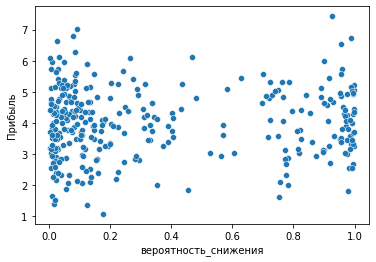

In [47]:
sns.scatterplot(data=X_test,
                x=X_test['вероятность_снижения'],
                y=X_test['Прибыль']);

Выделим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [48]:
group=X_test.query('вероятность_снижения >0.6 and Прибыль>4')

**Продуктовое поведение**

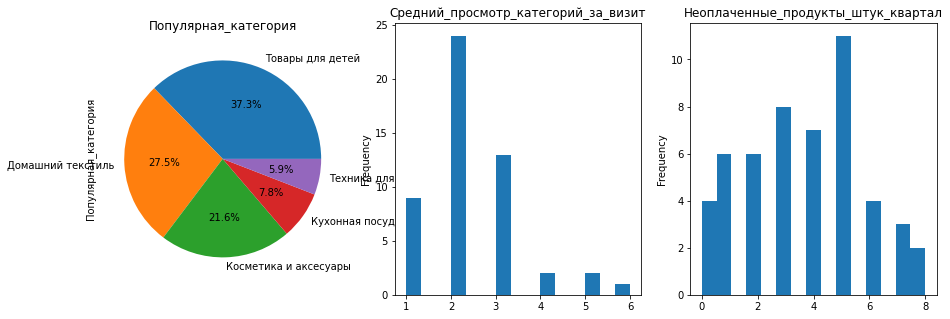

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
group['Популярная_категория'].value_counts().plot(kind='pie', 
                              autopct='%1.1f%%', ax=axes[0], title='Популярная_категория');
group['Средний_просмотр_категорий_за_визит'].plot(kind='hist',
                                                  bins= 15, ax=axes[1],
                                                  title = 'Средний_просмотр_категорий_за_визит');
group['Неоплаченные_продукты_штук_квартал'].plot(kind='hist',
                                                  bins= 15, ax=axes[2],
                                                  title = 'Неоплаченные_продукты_штук_квартал');

Наиболее популярна среди покупателей выбранного сегмента категория "Товары для детей", далее по популярности идут Домашний текстиль и Косметика и аксессуары. При этом покупатели чаще всего просматривают только 2 или 3 категории товаров. 
То есть либо покупатели ищут что-то конкретное, либо переход в другие категории на сайте для них не очевиден. Покупали часто передумывают или забывают о товарах в корзине - много неплаченных товаров

**Коммуникация с клиентом**

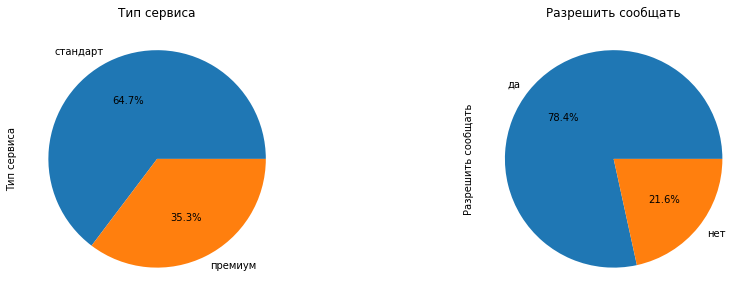

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
group['Тип сервиса'].value_counts().plot(kind='pie', 
                              autopct='%1.1f%%', ax=axes[0], title='Тип сервиса');
group['Разрешить сообщать'].value_counts().plot(kind='pie', 
                              autopct='%1.1f%%', ax=axes[1], title='Разрешить сообщать');

Преобладающее большинство пользователей изучаемого сегмента не пользуются премиум сервисом, но при этом они согласны получать рассылку с рекомендациями, чем и надо воспользоваться в этой ситуации.

Рекомендация: для покупателей с высокой вероятностью снижения активности и высокой прибыльностью необходимо расссылать рекламные предложения с преобладанием товаров для детей и для дома, но также включающих схожие товары из других категорий. Также необходимо уделить больше внимания рекламе премиум сервиса в этой категории покупателей, что позволит привлечь клиента больше взаимодействовать с магазином за счет преимуществ премиум сервиса.
Добавить рассылку о добавленных и неоплаченных товарах в корзине.

## Вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. 
Необходимо персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

Для выполнения работы были переданы 4 датасета:
1. df_file - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. df_market_money - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. df_money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
4. df_time - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Целевой признак - Покупательская активность

В признаках отствуют аномальные значения, за имсключением значений Выручки

В процессе предобработки данных были выполнены:
- Исследованы и удалены при наличии неявные дубликаты во всех датасетах
- Признаки поделены на качественные и количественные

В целом признаке Покупательская активность отмечен сильный дисбаланс классов.
Дисбаланс классов объясняется спецификой задачи, так как снижение активности фиксируется для небольшого процента покупателей. Нельзя устранить такой дисбаланс, не нарушив закономерности данных. Его нужно будет учитывать во время подготовки данных и обучения модели.

Среди пользователей, у которых покупательская активность снизилась, меньше доля пользователей премиум сервиса, но больше для подписок на рассылку. Самая популярная категория у обоих групп Товары для детей. В целом для обоих групп пользователей, разделенных по целевому признаку, не наблюдается существенных различий в интересах по категориям товаров

Анализ распределения количественных признаков показал, что пользователи, у которых снизилась активность: - просматривают меньше страниц при посещении сайта
- чаще имеют дело с ошибками сервиса
- имеют больше неоплаченных продуктов
- просматривают за визит меньше категорий

После удаления одного максимального выброса, значения выручки описываются нормальным распределением, но отмечается все еще много выбросов за счет явного преобладания значений выручки близким к среднему.
Данные о минутах проведенных на сайте распределены нормально, выбросы отсутсвуют
Данные о прибыли проведенных на сайте распределены нормально, присутствует незначительное кол-во выбросов

Мультиколлинеарность признаков отсутствует. Наиболее высокая корреляция признаков наблюдается между выручкой в текущем и прошлом месяце. 
Самый высокий коэффциент корреляции с целевым признаком у признака Страниц за визит

Лучшая модель и её параметры:
LogisticRegression(C=3, penalty='l1', random_state=123,
                                    solver='liblinear'))])
Метрика лучшей модели на тренировочной выборке: 0.9086058881676875
Метрика ROC-AUC на тестовой выборке: 0.8552896673656512

Анализ важности признаков показал, что:
Мало значимы для модели:
- Ошибка сервиса
- Длительность
- Категории товаров Товары для детей и Кухонная посуда
- Количество маркетинговых коммуникаций в текущем месяце

Сильнее всего влияют на целевой признак:
- Кол-во страниц за визит
- Кол-во минут на сайте
- Среднее кол-во категорий за визит
- Кол-во неоплаченных продуктов

При моделировании значимость признаков для модели можно использовать для ее улучшения, например больше внимания уделить их анализу или сгенерирвоать новые на их основе
В процессе принятия бизнес-решений важность признаков должна использоваться для лучшего понимания поведения пользователя и взаимодействия с ним, выдвижения гипотез на их основе.

 **Рекомендация**

Для покупателей с высокой вероятностью снижения активности и высокой прибыльностью необходимо расссылать рекламные предложения с преобладанием товаров для детей и для дома, но также включающих схожие товары из других категорий. Также необходимо уделить больше внимания рекламе премиум сервиса в этой категории покупателей, что позволит привлечь клиента больше взаимодействовать с магазином за счет преимуществ премиум сервиса.
Добавить рассылку о добавленных и неоплаченных товарах в корзине.